<a href="https://colab.research.google.com/github/blabossiere/cap-comp215/blob/main/Comp_215_Project_2_Monday_April_8%2C_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Computer Science 215 Project 2 \
Friday April 12, 2024 \
Brayden Labossiere \

Notes on my project: \

My project attempts to simulate the interactions between deer and the environment.  The deer are represented in blue, and there are 10 possible states of deer health, the strongest being navy and the weakest being dark blue. The grass is represented in green, and the barren cells (no grass) are represented in brown. \

There is an inherent bias present, which results from the way I have completed the project.  Because the deer will only move to a new cell that is unoccupied, and the array is looped through systematically, deer in the top/left are given more priority in movement.  However, this bias is small and does not come into account when the numbers of deer are kept small. This is because there are less deer, the chance of deer coming close together is becomes smaller. \

Even though the arrays that represent the landscape and the status of the deer work properly, sometimes in the animation, the green cells representing the grass disappear periodically (i.e. for a timestep or two), and I cannot figure out why this is the case. While this can make it challenging to the view the animation, it does not have an effect on the functioning of the model itself. The actual arrays and percentages in the title are consistently accurate. \

From this simple model, I discovered that the success of the grass and the deer as species are closely tied together.  Without the grass, the deer cannot survive and will all pass away.  However, if there are too many deer, there will be less grass for each deer, and the deer as a species will suffer.  

In [1]:
# import modules

%matplotlib inline

import time
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from scipy.signal import correlate2d
import math

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

In [2]:
# Qualitative colour map with value 0 set to white

tab20_mod = matplotlib.colormaps['tab20']
tab20_mod.colors = ((1,1,1,1), *tab20_mod.colors[1:])

def plot_2d_array(array, axes=None, title='', cmap=tab20_mod, **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    # Turn off axes labels and tick marks
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False ,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

In [3]:
# Animation Class

class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

In [4]:
class Landscape:
  """A class that creates and updates the landscapes with two possible states, grass, (1), or barren, (0)."""

  # Define names for the 2 possible cell states of landscape.
  BARREN = 0
  GRASS = 1

  # Define a colour map that maps each cell state to an intuitive colour.
  cmap = [(0.1333,0.545,0.1333), (0.87,0.722,0.529)]
  cmap[BARREN] = (0.87,0.722,0.529)  # brown
  cmap[GRASS] = (0.1333,0.545,0.1333)  # green
  landscape_colour_map = matplotlib.colors.ListedColormap(cmap)

  def __init__(self, n=10, q=0.5, r=0.3):
    """
    Takes the input of n, q, and r and creates a random starting landscape based on the inputted parameters.
    n: the column and row size of the array
    q: the probability that the intial landscape is filled with grass.
    r: the probability that the barren cells regrow into grass-filled cells.
    """

    self.n = n
    self.q = q
    self.r = r
    self.state = np.random.choice([self.GRASS, self.BARREN], (self.n, self.n), p=[self.q, 1 - self.q])

  def step(self):
    """Updates the landscape with each time step.  The chance that a barren cell will grow back into a grass cell will occur with the regeneration probability, r."""
    for y in range(self.n):
      for x in range(self.n):
        if self.state[y][x] == 0:
          new_number = np.random.choice([self.GRASS, self.BARREN], (1, 1), p=[self.r, 1 - self.r])
          self.state[y][x] = new_number

  def num_occupied(self):
        """ return the number of cells occupied by grass """
        grass_count = 0
        for row in range(self.n):
          for row_index in range(self.n):
            if self.state[row][row_index] == 1:
              grass_count = grass_count + 1
        return grass_count


  def pct_occupied(self):
    """ return the proportion of cells occupied by forest """
    return self.num_occupied() / self.state.size


  def draw(self, axes=None, step=''):
    """Draws the CA cells using the landscape colour map so values are coloured intuitively."""
    axes = axes or plt.gca()
    title = f'Time:{step} Occupied: {round(self.pct_occupied() * 100, 2)}%'
    plot_2d_array(self.state, axes=axes, title=title,
                  cmap=self.landscape_colour_map, vmin=0, vmax=len(self.landscape_colour_map.colors))

# print(cmap[BARREN])
# print(landscape_colour_map)

grassland1 = Landscape(n=10, q=0.5, r=0.3)
grassland1.state
# grassland1.step()
grassland1.state

array([[0, 1, 1, 1, 0, 0, 1, 0, 0, 1],
       [1, 1, 1, 0, 1, 0, 0, 1, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 1, 1, 0, 1, 0, 0, 1],
       [0, 1, 1, 1, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
       [1, 1, 1, 0, 1, 0, 1, 1, 1, 0],
       [0, 1, 0, 0, 1, 1, 0, 0, 0, 1],
       [1, 0, 1, 0, 1, 0, 0, 1, 0, 1],
       [1, 1, 1, 0, 0, 0, 0, 1, 1, 0]])

In [5]:
class Deermap:
  """A class that creates an initial with map of deer."""

  # Define names for the possible deer states
  NO_DEER = 0
  DEER = 2



  # Define a colour map that maps each deer state to an colour, with a gradient of blue representing the health status of each deer.
  """The darker the blue, the more health the deer has."""
  cmap2 = [(1, 1, 1), (1, 1, 1), (0.7, 0.7, 1), (0.6, 0.6, 1), (0.5, 0.5, 1), (0.4, 0.4, 1), (0.3, 0.3, 1), (0.2, 0.2, 0.9), (0.1, 0.1, 1), (0, 0, 0.9), (0, 0, 0.7), (0, 0, 0.5)]
  deer_colour_map = matplotlib.colors.ListedColormap(cmap2)

  def __init__(self, n=10, d=0.3): # s = 0.5?
    """
    Takes the parameters of n and d.  Creates a map of deer based on the inputted parameters.
    n: the column and row size of the array
    d: the initial proportion of the landscape occupied by deer.
    #s: the proportion that a deer will respawn somewhere on the map.
    """

    self.n = n
    self.d = d

    self.state = np.random.choice([self.DEER, self.NO_DEER], (self.n, self.n), p=[self.d, 1 - self.d])

    """Takes all deer and provides them with a random starting health, from 1 to 10."""
    for y in range(self.n):
      for x in range(self.n):
        if self.state[y][x] == 2:
          new_number = np.random.choice(range(2, 12))
          self.state[y][x] = new_number

  def deer_occupied(self):
    """ return the number of cells occupied by deer """
    deer_count = 0
    for row in range(self.n):
      for row_index in range(self.n):
        if self.state[row][row_index] > 0:
          deer_count = deer_count + 1
    return deer_count


  def pct_occupied(self):
    """ return the proportion of cells occupied by deer"""
    return self.deer_occupied() / self.state.size


  def draw(self, axes=None, step=''):
    """Draws the CA cells using the deer colour map so values are coloured intuitively."""
    axes = axes or plt.gca()
    title = f'Time:{step} Occupied: {round(self.pct_occupied() * 100, 2)}%'
    plot_2d_array(self.state, axes=axes, title=title,
                  cmap=self.deer_colour_map, vmin=0, vmax=len(self.deer_colour_map.colors))

deer_map1 = Deermap(n=10, d=0.3)
deer_map1.state

array([[ 0,  0,  2,  3,  0,  6, 11,  0,  0,  6],
       [ 4,  7,  7,  0,  0,  0,  0, 11,  0,  0],
       [ 0, 10,  0,  6,  0,  0,  0,  4,  4,  0],
       [ 0,  0, 10,  0,  0,  0,  0,  0,  8,  8],
       [ 5,  0,  0,  0, 11,  0,  8,  0,  0,  9],
       [ 4,  0,  5,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0, 10,  0,  9, 10,  0,  0],
       [ 0,  0,  7,  0,  0,  0,  0,  0, 10,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  4],
       [ 0,  0,  4,  4,  0,  0,  0,  0,  4,  8]])

In [6]:
chris = Deermap(n=10, d=0.3)
print(chris.state)
animator = Animation2D(chris, frames=1, steps_per_frame=1, figsize=(8, 8))
animator.show()

[[ 0  0  0  0  8  0  0  0  0  4]
 [ 4  4  0 11  4  2  0  0  5 11]
 [ 6 10 10  0  0  0  0  0  0  7]
 [ 0  0 10  0  0  0  0  0  0  5]
 [ 0  2  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  0  7  0]
 [ 2  0  0  0  3  0  0 10  0  0]
 [ 0  0  0 11  0  8  3  0  6  0]
 [ 0  0  0  0  0  0  0  5  0  0]
 [ 0  0  4  0 10  0  6 11  2  9]]


In [7]:
dan = Landscape(n=10, q=0.5, r=0.3)
animator = Animation2D(dan, frames=20, steps_per_frame=1, figsize=(8, 8))
animator.show()
#animator.animate()

<ipython-input-4-ceb7faf38767>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.state[y][x] = new_number


<ipython-input-4-ceb7faf38767>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.state[y][x] = new_number


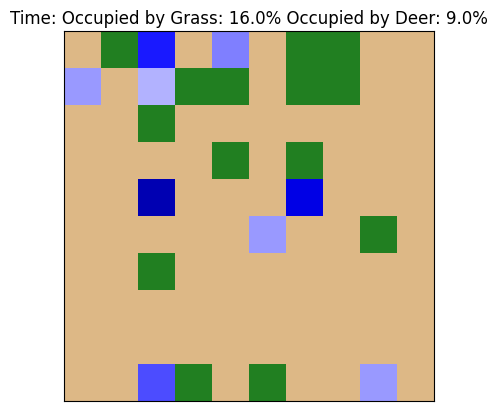

In [21]:
class Deer_and_Grass_Map:
  """A class that uses all the parameters of n, q, r, and d to create instances from the deermap and grassmap classes.  The grassmap and deermap will combine to form a super map."""

  def __init__(self, n=10, q=0.1, r=0.01, d=0.1):
    """
    n: the column and row size of the array
    q: the probability that the intial landscape is filled with grass.
    r: the probability that the barren cells regrow into grass-filled cells.
    d: the initial proportion of the landscape occupied by deer.
    """
    self.n = n
    self.q = q
    self.r = r
    self.d = d

    self.deermap = Deermap(self.n, self.d)
    self.grassmap = Landscape(self.n, self.q, self.r)

  def move_deer(self, y1, x1):
    """A function that moves a deer at random, left, right, up, or down.  Returns a new location (y, x) for the deer to move to."""

    #xy = (x1, y1)

    x_or_y_change = np.random.choice(['x1', 'y1'], p=[0.5, 0.5])

    if x_or_y_change == 'x1':
      new_x = np.random.choice([(x1+1), (x1-1)], p=[0.5, 0.5])
      x1 = new_x
    else:
      new_y = np.random.choice([(y1+1), (y1-1)], p=[0.5, 0.5])
      y1 = new_y
    # Wrap the edges
    if x1 > (self.n - 1):
      x1 = 0
    if y1 > (self.n - 1):
      y1 = 0
    if x1 < 0:
      x1 = (self.n - 1)
    if y1 < 0:
      y1 = (self.n - 1)
    return (y1, x1)

  def step(self):
    """Updates the combined map so that deers either eat grass they stand on and move to a surrounding cell (health increases by 3) or move to a surrounding cell
    (health decreases by 1).  Then, the grass will regererate with the regeneration probability, p."""
    for y in range(self.n):
      for x in range(self.n):
        x2 = 0
        y2 = 0

        if self.deermap.state[y][x] > 0:
          if self.grassmap.state[y][x] == 0: # If deer is standing on a barren cell
            self.deermap.state[y][x] = self.deermap.state[y][x] -1 # decreases the deer's health by 1 if it is not standing on grass.
          if self.grassmap.state[y][x] == 1: # If deer is standing on grass, and below the max health threshold, add 3 health.
            if self.deermap.state[y][x] <= 7:
              self.grassmap.state[y][x] = 0
              self.deermap.state[y][x] = self.deermap.state[y][x] + 3

          """Moves the deer up, down, left, or right, and leaves the cell that the deer walked away from empty."""
          new_deer_coord = self.move_deer(y, x) # new_deer_coord is a location (y, x) on the deermap grid
          new_y = new_deer_coord[0]
          new_x = new_deer_coord[1]
          count = 25 # Deer will stay still if surrounded on all four sides. It is unlikely that a deer will attempt to move to its inhabitaed neighbour's cells 25 times in a row if not all four neighbouring cells are occupied.
          while self.deermap.state[new_y][new_x] > 0: # Don't go to the same spot that is currently occupied by a deer.
            new_deer_coord = self.move_deer(y, x)
            new_y = new_deer_coord[0]
            new_x = new_deer_coord[1]
            count = count - 1
            if count == 0: #Deer remains at its position if it is surrounded on all four sides.
              new_y = y
              new_x = x

          self.deermap.state[new_y][new_x] = self.deermap.state[y][x] # "Moves" the deer to one of the cells of its cardinal neighbours.
          self.deermap.state[y][x] = 0 # "Removes" the deer from its previous spot.
          # self.grassmap.step() # Regenerates the grass at each barren cell with the regeneration probability, r

  def draw(self, axes=None, step=''):
    """Draw the two arrays superimposed on each other.  First, an empty array is created.  The deer are added.  Then, the landscape cells are added
    everywhere where there are no deer occupying the cell."""

    super_map = np.zeros(shape = (self.n, self.n), dtype=np.uint8)
    for y4 in range(self.n):
      for x4 in range(self.n):
        if self.deermap.state[y4][x4] > 1: # Only adds the deer to the map
          super_map[y4][x4] = self.deermap.state[y4][x4]
        else:
          super_map[y4][x4] = self.grassmap.state[y4][x4]
    self.grassmap.step() # Regenerates the grass at each barren cell with the regeneration probability, r
    self.state = super_map

    # Define names for the 2 possible cell states of landscape.
    BARREN = 0
    GRASS = 1

    # Define a colour map that maps each deer state to an colour, with a gradient of blue representing the health status of each deer, 2-11.
    # The darker the blue, the stronger the deer.  If a deer reaches 1, the deer dies.
    # Additionally, the colour map includes colours for the barren and grass landscapes, in the indexes 0 and 1.
    """The darker the blue, the more health the deer has."""
    cmap2 = cmap2 = [(1, 1, 1), (0.7, 0.7, 1), (0.6, 0.6, 1), (0.5, 0.5, 1), (0.4, 0.4, 1), (0.3, 0.3, 1), (0.2, 0.2, 0.9), (0.1, 0.1, 1), (0, 0, 0.9), (0, 0, 0.7), (0, 0, 0.5)]
    deer_colour_map = matplotlib.colors.ListedColormap(cmap2)

    # Define a colour map that maps each cell state to its designated colour.
    cmap = [(0.87,0.722,0.529), (0.1333,0.545,0.1333)]
    cmap[BARREN] = (0.87,0.722,0.529)  # brown
    cmap[GRASS] = (0.1333,0.545,0.1333)  # green
    landscape_colour_map = matplotlib.colors.ListedColormap(cmap)

    cmap3 = [(0.87,0.722,0.529), (0.13,0.5,0.13), (0.7, 0.7, 1), (0.6, 0.6, 1), (0.5, 0.5, 1), (0.4, 0.4, 1), (0.3, 0.3, 1), (0.2, 0.2, 0.9), (0.1, 0.1, 1), (0, 0, 0.9), (0, 0, 0.7), (0, 0, 0.5)]
    super_colour_map = matplotlib.colors.ListedColormap(cmap3)

    """Draws the CA cells using the combined colour map so values are coloured according to their value."""
    axes = axes or plt.gca()
    title = f'Time:{step} Occupied by Grass: {round(self.grassmap.pct_occupied() * 100, 2)}% Occupied by Deer: {round(self.deermap.pct_occupied() * 100, 2)}%'
    plot_2d_array(super_map, axes=axes, title=title,
                  cmap=super_colour_map, vmin=0, vmax=len(super_colour_map.colors))

# Test Cases

"""
n: the column and row size of the array
q: the probability that the intial landscape is filled with grass.
r: the probability that the barren cells regrow into grass-filled cells.
d: the initial proportion of the landscape occupied by deer.
"""

test_map = Deer_and_Grass_Map(n=10, q=0.1, r=0.01, d=0.1)

test_map.draw()

In [23]:
map2 = Deer_and_Grass_Map(n=10, q=0.1, r=0.02, d=0.1)
animator = Animation2D(map2, frames=20, steps_per_frame=1, figsize=(8, 8))
animator.show()
# animator = Animation2D(test_map, frames=20, steps_per_frame=1, figsize=(8, 8))
# animator.animate()

<ipython-input-4-ceb7faf38767>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.state[y][x] = new_number
